# Joint domain detection for spatial transcriptomics and proteiomics data

In this section, we introduce stMSA for integrating RNA and protein data.

In [1]:
import scanpy as sc
import numpy as np
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix

import st_datasets as stds
from train_integrate import train_integration
from stMSA.utils import get_palette

## Load and preprocess

We preprocessed RNA and protein data and use the top 300 PCs to train stMSA.

In [ ]:
raw_rna_adata = sc.read_visium('data/tonsil_visium')
raw_rna_adata.obsm['spatial'] = np.float32(raw_rna_adata.obsm['spatial'])
raw_rna_adata.var_names_make_unique()
raw_rna_adata.obs_names_make_unique()
raw_protein_adata = sc.read("data/tonsil_protein.h5ad")

sc.pp.normalize_total(raw_rna_adata, target_sum=1e4)
sc.pp.normalize_total(raw_protein_adata, target_sum=1e4)
sc.pp.log1p(raw_rna_adata)
sc.pp.log1p(raw_protein_adata)
sc.pp.highly_variable_genes(raw_rna_adata, n_top_genes=400)

pca = PCA(n_components=300, random_state=0)
rna_adata = sc.AnnData(csr_matrix(pca.fit_transform(raw_rna_adata[:, raw_rna_adata.var['highly_variable']].X.toarray())))
rna_adata.obsm['spatial'] = raw_rna_adata.obsm['spatial']
protein_adata = sc.AnnData(csr_matrix(pca.fit_transform(raw_protein_adata.X.toarray())))
protein_adata.obsm['spatial'] = raw_protein_adata.obsm['spatial']

## Train stMSA

When integrating datasets from multiple platforms, variations in coordinate system scales (e.g., pixel vs. um) can cause inconsistencies in spatial graph construction. Using a fixed radius threshold across all platforms may lead to skewed adjacency links, where some datasets might produce overly dense or excessively sparse graphs. To address this, users can manualy build the spatial graph first and input the spatial graph using the `graph` parameter to stMSA

In [ ]:
adatas = sc.concat((protein_adata, rna_adata), label='batch')
graph = stds.pp.concat_adjacency_matrix(adata_list=[
    protein_adata, rna_adata
], edge_list=[
    stds.pp.build_graph(protein_adata, radius=1),
    stds.pp.build_graph(rna_adata, radius=400),
])
adatas = train_integration(adatas, graph=graph)

>>> INFO: Generate 12236 edges, 3.910 edges per spot.(0.012s)
>>> INFO: Generate 33788 edges, 5.884 edges per spot.(0.021s)
>>> INFO: Finish generate precluster embedding(5.557s)!


  1%|▏         | 7/500 [00:01<00:59,  8.31it/s]

>>> INFO: Finish finding mmn pairs, find 96505 mnn node pairs(0.377s)!


 21%|██        | 105/500 [00:03<00:15, 25.45it/s]

>>> INFO: Finish finding mmn pairs, find 108588 mnn node pairs(0.342s)!


 42%|████▏     | 208/500 [00:05<00:11, 26.50it/s]

>>> INFO: Finish finding mmn pairs, find 115229 mnn node pairs(0.347s)!


 62%|██████▏   | 310/500 [00:08<00:06, 27.61it/s]

>>> INFO: Finish finding mmn pairs, find 120042 mnn node pairs(0.347s)!


 81%|████████▏ | 407/500 [00:10<00:03, 30.78it/s]

>>> INFO: Finish finding mmn pairs, find 123321 mnn node pairs(0.329s)!


100%|██████████| 500/500 [00:12<00:00, 39.93it/s]


## Visialization

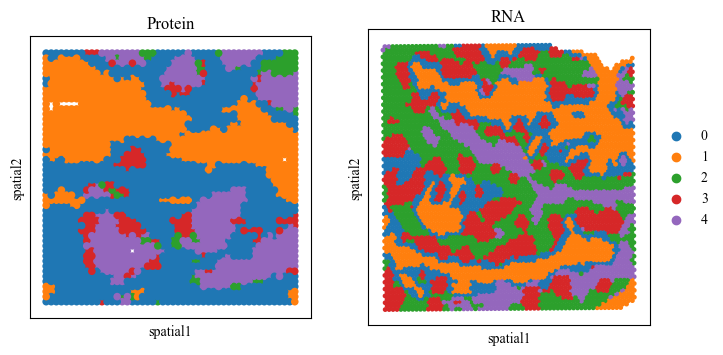

In [4]:
sc.pp.neighbors(adatas, use_rep='embedding')
sc.tl.louvain(adatas, resolution=0.4)
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, 2, figsize=(8, 18)) 
sc.pl.spatial(adatas['0' == adatas.obs['batch']], color="louvain", title="Protein", img_key=None, spot_size=1.5, show=False, ax=axes[0], legend_loc=None)
sc.pl.spatial(adatas['1' == adatas.obs['batch']], color="louvain", title="RNA", img_key=None, spot_size=450, show=False, ax=axes[1])
plt.show()